##  Feature Selection

Feature selection is a crucial step in machine learning that helps improve model performance, reduce overfitting, and speed up training time by selecting the most relevant features from the dataset.

There are three main types of feature selection methods:

* Filter Methods (Based on statistical measures)
* Wrapper Methods (Based on model performance)
* Embedded Methods (Feature selection integrated within the model)

Why feature selection?

* Removes irrelevant or redundant features
* Reduces computational complexity
* Helps avoid the curse of dimensionality
* Improves model interpretability
* Enhances generalization by reducing overfitting

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Filter Methods (Statistical approaches)

Filter methods evaluate the relevance of features based on statistical measures before training a model. These methods rank features according to their correlation with the target variable and select the most relevant ones.

### **Characteristics:**
- **Independent of the model:** Feature selection is performed before training the model.
- **Fast and computationally efficient:** Since no model training is required, they are suitable for large datasets.
- **Prone to selecting irrelevant features:** They do not consider interactions between features.
- **Common techniques:**
  - Pearson correlation coefficient
  - Mutual information
  - Chi-square test
  - ANOVA (Analysis of Variance)
  - Variance thresholding

In [15]:
#| echo: false

# import image module
from IPython.display import Image

# get the image
Image(url="./Datasets/filter_methods.png",width=700, height=300)

### Methods

| Method               | Description                                         | Python Function/Class              | Notes |
|----------------------|-----------------------------------------------------|------------------------------------|-------------------------------------------------|
| **Variance Threshold** | Removes low-variance numeric features              | `VarianceThreshold()` (scikit-learn) | Only works on numerical features |
| **Correlation Filter** | Removes highly correlated features                 | Custom implementation + `df.corr()` | Requires manual analysis (pandas) or `correlation_threshold` methods |
| **Chi-Square Test**   | Selects categorical features for classification     | `chi2()` + `SelectKBest()`        | For categorical targets, requires non-negative features |
| **Mutual Information** | Measures dependency for classification/regression  | `mutual_info_classif()`/`regression()` | Used with `SelectKBest()` or `SelectPercentile()` |


In [16]:

from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression

# Load the data
df = pd.read_csv('./Datasets/Credit.csv', index_col=0)

# Separate features and target
# Let's use 'Balance' as our target variable
X = df.drop('Balance', axis=1)
y = df['Balance']

# Preprocessing: Encode categorical variables
X_encoded = pd.get_dummies(X, columns=['Gender', 'Student', 'Married', 'Ethnicity'])

# 1. Variance Threshold Feature Selection
def variance_threshold_selection(X, threshold=0.1):
    # Create a VarianceThreshold selector
    selector = VarianceThreshold(threshold=threshold)
    
    # Fit and transform the data
    X_selected = selector.fit_transform(X)
    
    # Get the selected feature names
    selected_features = X.columns[selector.get_support()]
    
    return X_selected, selected_features

# Apply Variance Threshold
X_var_selected, var_selected_features = variance_threshold_selection(X_encoded)

print("1. Variance Threshold Feature Selection:")
print("Selected features:", list(var_selected_features))
print("Number of features reduced from", X_encoded.shape[1], "to", len(var_selected_features))


1. Variance Threshold Feature Selection:
Selected features: ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Gender_ Male', 'Gender_Female', 'Married_No', 'Married_Yes', 'Ethnicity_African American', 'Ethnicity_Asian', 'Ethnicity_Caucasian']
Number of features reduced from 15 to 13



3. Correlation-based Feature Removal:
Dropped features: ['Rating', 'Gender_Female', 'Student_Yes', 'Married_Yes']
Number of features reduced from 15 to 11


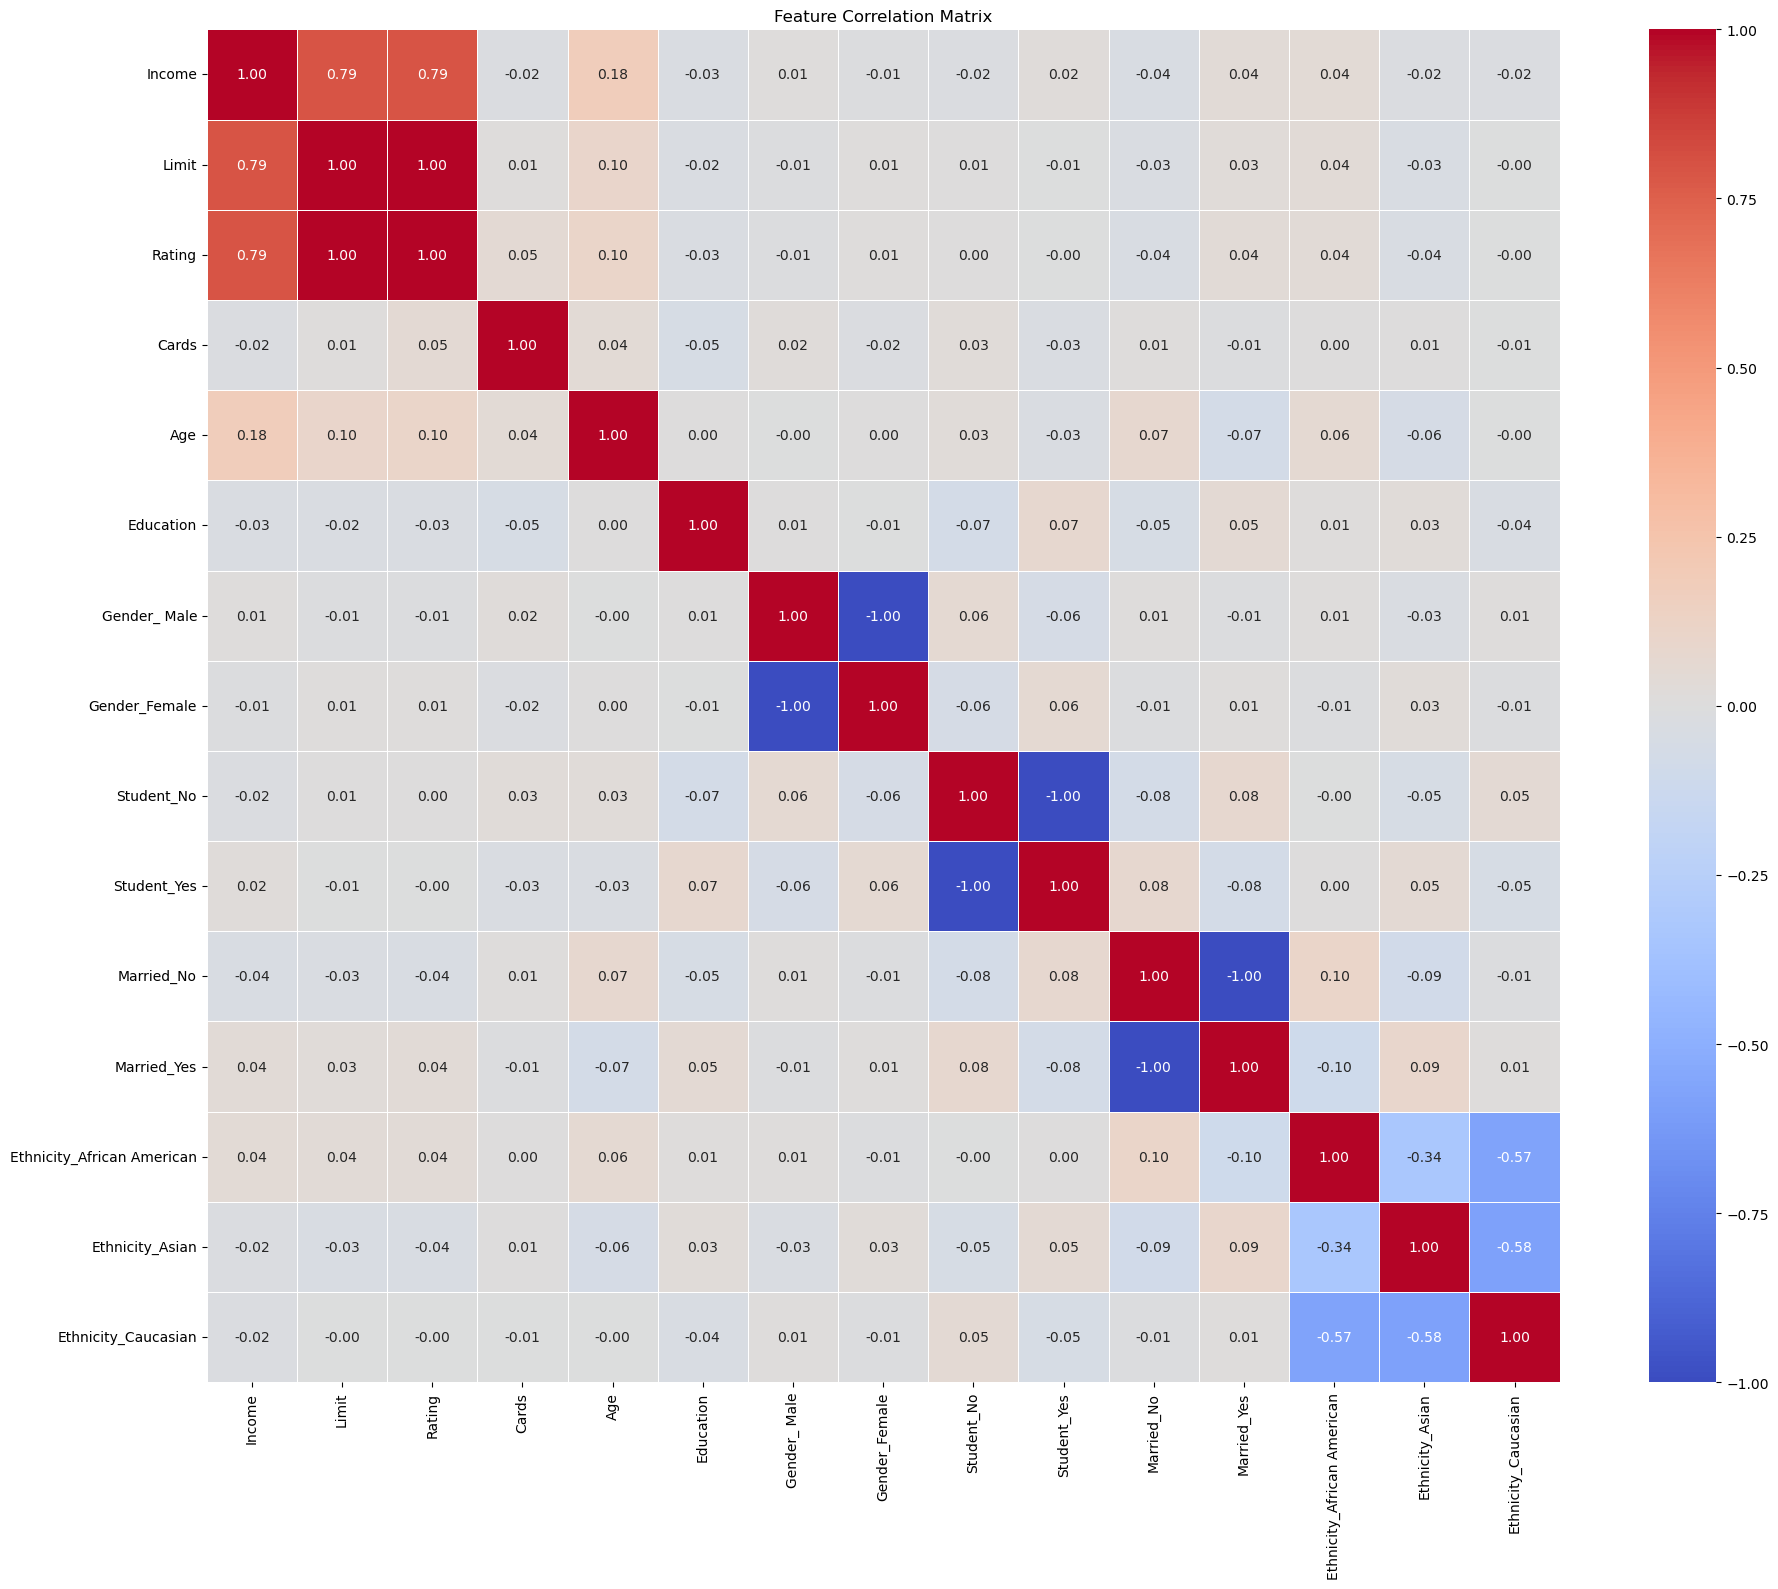

In [ ]:
# 2. Correlation-based Feature Removal
def remove_highly_correlated_features(X, threshold=0.8):
    # Compute the correlation matrix
    corr_matrix = X.corr().abs()
    
    # Create a mask of the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features to drop
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Drop highly correlated features
    X_reduced = X.drop(columns=to_drop)
    
    return X_reduced, to_drop

# Apply Correlation-based Feature Removal
X_corr_removed, dropped_features = remove_highly_correlated_features(X_encoded)

print("\n3. Correlation-based Feature Removal:")
print("Dropped features:", dropped_features)
print("Number of features reduced from", X_encoded.shape[1], "to", X_corr_removed.shape[1])

# Visualization of Correlation Matrix
plt.figure(figsize=(20,16))
correlation_matrix = X_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout();

In [6]:
# 3. Correlation-based Feature Selection (with target)
def correlation_with_target_selection(X, y, threshold=0.2):
    # Calculate correlation with target
    correlations = X.apply(lambda col: col.corr(y))
    
    # Select features above the absolute correlation threshold
    selected_features = correlations[abs(correlations) >= threshold].index
    
    return X[selected_features], selected_features

# Apply Correlation with Target Selection
X_corr_target, corr_target_features = correlation_with_target_selection(X_encoded, y)

print("\n2. Correlation with Target Feature Selection:")
print("Selected features:", list(corr_target_features))
print("Number of features reduced from", X_encoded.shape[1], "to", len(corr_target_features))


2. Correlation with Target Feature Selection:
Selected features: ['Income', 'Limit', 'Rating', 'Student_No', 'Student_Yes']
Number of features reduced from 15 to 5


Correlations with Balance (sorted by absolute value):
Rating: 0.863625160621495
Limit: 0.8616972670153951
Income: 0.46365645701575736
Student_No: 0.2590175474501476
Student_Yes: 0.2590175474501476
Cards: 0.08645634741861911
Gender_ Male: 0.021474006717338588
Gender_Female: 0.021474006717338588
Ethnicity_African American: 0.013719801718047214
Ethnicity_Asian: 0.00981223592782398
Education: 0.00806157645355343
Married_Yes: 0.005673490217239985
Married_No: 0.005673490217239973
Ethnicity_Caucasian: 0.003288321172097514
Age: 0.0018351188590736563


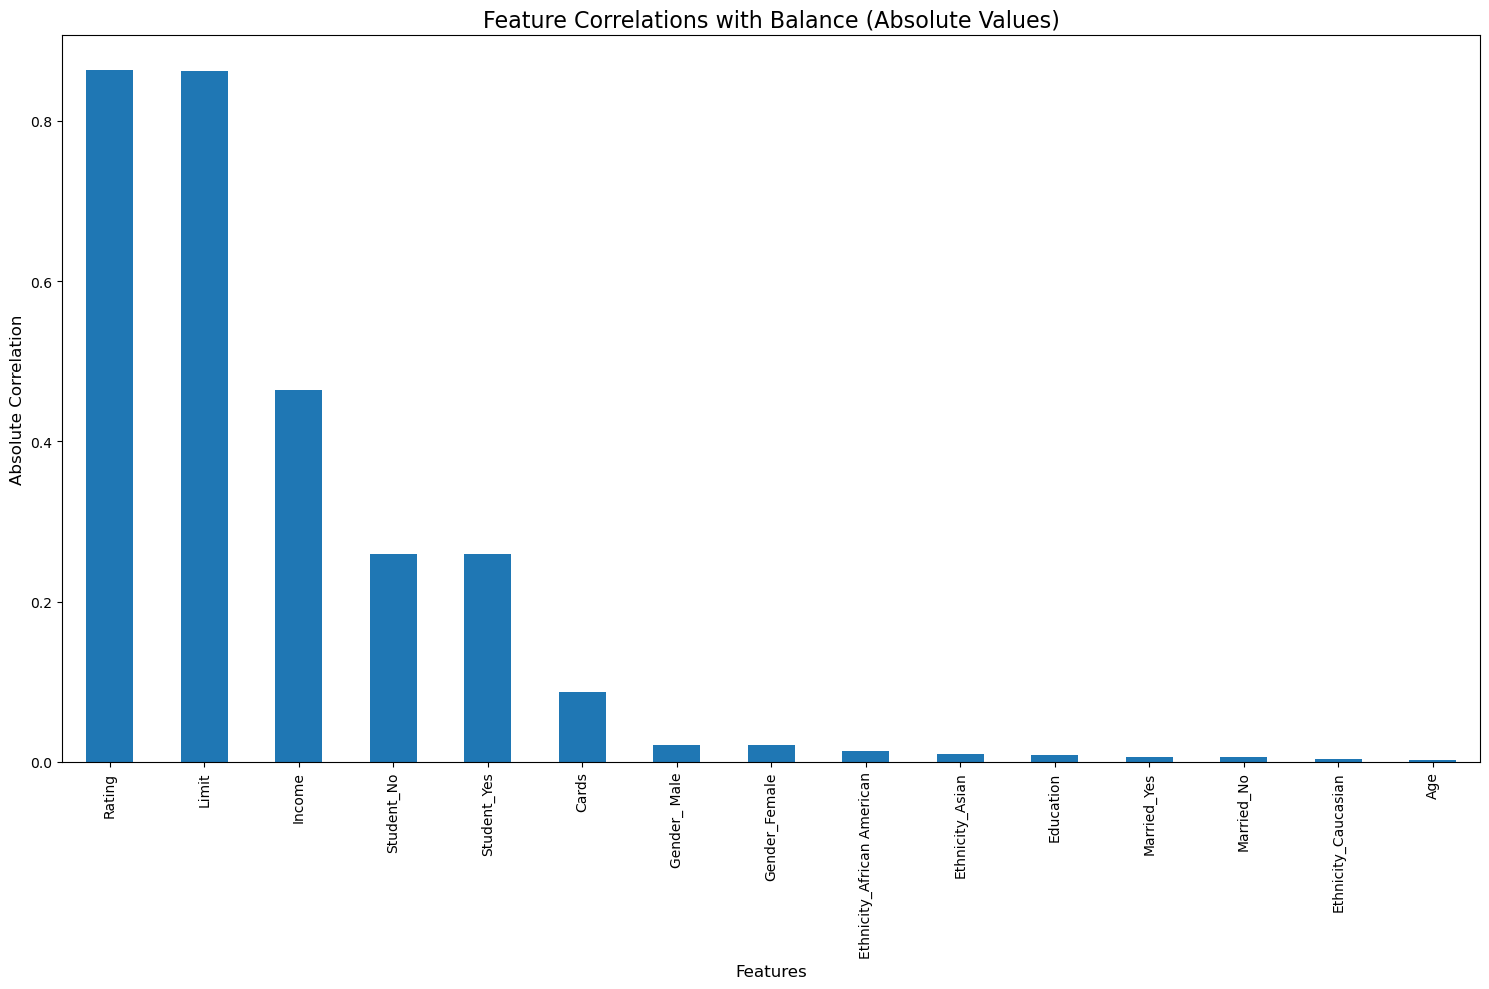

In [7]:
# Calculate correlations with target
correlations = X_encoded.apply(lambda col: col.corr(y))

# Sort correlations by absolute value in descending order
correlations_sorted = correlations.abs().sort_values(ascending=False)

# Prepare the visualization
plt.figure(figsize=(15, 10))
correlations_sorted.plot(kind='bar')
plt.title('Feature Correlations with Balance (Absolute Values)', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Absolute Correlation', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()

# Print out the sorted correlations
print("Correlations with Balance (sorted by absolute value):")
for feature, corr in correlations_sorted.items():
    print(f"{feature}: {corr}")

In [8]:
# 4. SelectKBest Feature Selection
def select_k_best_features(X, y, k=5):
    # Create a SelectKBest selector
    selector = SelectKBest(score_func=f_regression, k=k)
    
    # Fit and transform the data
    X_selected = selector.fit_transform(X, y)
    
    # Get the selected feature names
    selected_features = X.columns[selector.get_support()]
    
    return X_selected, selected_features

# Apply SelectKBest
X_k_best, k_best_features = select_k_best_features(X_encoded, y)

print("\n4. SelectKBest Feature Selection:")
print("Selected features:", list(k_best_features))
print("Number of features reduced from", X_encoded.shape[1], "to", len(k_best_features))


4. SelectKBest Feature Selection:
Selected features: ['Income', 'Limit', 'Rating', 'Student_No', 'Student_Yes']
Number of features reduced from 15 to 5


##  Wrapper Methods

Wrapper methods evaluate subsets of features by actually training and testing a model on different feature combinations. These methods optimize feature selection based on model performance.

### Characteristics:
- **Model-dependent:** They rely on training a model to assess feature usefulness.
- **Computationally expensive:** Since multiple models need to be trained, they can be slow, especially for large datasets.
- **More accurate than filter methods:** They account for feature interactions and can find the optimal subset.
- **Risk of overfitting:** Since they optimize for a specific dataset, the selected features may not generalize well to new data.
- **Common techniques:**
  - Recursive Feature Elimination (RFE)
  - Sequential Feature Selection (SFS) (Forward/Backward Selection)

  
- Wrapper methods can be explained with the help of following graphic:

In [29]:
#| echo: false

# import image module
from IPython.display import Image

# get the image
Image(url="./Datasets/wrapper.webp",width=800, height=200)

### Recursive Feature Elimination (RFE)

This is how RFE works:

* Start with all features in the dataset.
* Train a model (e.g., Random Forest, SVM, Logistic Regression).
* Rank feature importance using model coefficients (`coef_`) or feature importance scores (`feature_importances_`).
* Remove the least important feature(s).
* Repeat steps 2-4 recursively until reaching the desired number of features.
* Return the best subset of features.

In [17]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier


# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Initialize a model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Apply Recursive Feature Elimination (RFE)
rfe_selector = RFE(model, n_features_to_select=5)  # Select top 5 features
X_rfe_selected = rfe_selector.fit_transform(X, y)

# Get selected feature names
rfe_selected_features = X.columns[rfe_selector.support_]
print("Selected features using RFE:", rfe_selected_features.tolist())


Selected features using RFE: ['mean concave points', 'worst radius', 'worst perimeter', 'worst area', 'worst concave points']


### Recursive Feature Elimination with Cross-Validation (RFECV)

RFECV is an extension of Recursive Feature Elimination (RFE) that automatically selects the optimal number of features using cross-validation.

In [18]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Initialize model (Random Forest)
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5)

# Apply RFECV
rfecv_selector = RFECV(estimator=model, step=1, cv=cv, scoring='accuracy', n_jobs=-1)
X_rfecv_selected = rfecv_selector.fit_transform(X, y)

# Get selected feature names
rfecv_selected_features = X.columns[rfecv_selector.support_]
print("Optimal number of features:", rfecv_selector.n_features_)
print("Selected features using RFECV:", rfecv_selected_features.tolist())

# Print feature rankings
feature_ranking = pd.DataFrame({'Feature': X.columns, 'Ranking': rfecv_selector.ranking_})
print(feature_ranking.sort_values(by='Ranking'))


Optimal number of features: 16
Selected features using RFECV: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'radius error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points']
                    Feature  Ranking
0               mean radius        1
22          worst perimeter        1
23               worst area        1
13               area error        1
24         worst smoothness        1
25        worst compactness        1
10             radius error        1
21            worst texture        1
26          worst concavity        1
7       mean concave points        1
6            mean concavity        1
3                 mean area        1
2            mean perimeter        1
1              mean texture        1
27     worst concave points        1
20             worst radius        1
28           worst symmet

### Sequential Feature Selection

SFS iteratively selects the most relevant features by **adding them one at a time (forward selection)** or **removing them one at a time (backward elimination)** while evaluating model performance at each step. 

The selection strategy is controlled using:
- `direction='forward'` for **feature addition**
- `direction='backward'` for **feature removal**


In [21]:
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.linear_model import LogisticRegression

# Initialize a model
model = LogisticRegression(max_iter=1000)

# Apply Sequential Feature Selection (SFS)
sfs_selector = SequentialFeatureSelector(model, n_features_to_select=5, direction='forward', n_jobs=-1)
X_sfs_selected = sfs_selector.fit_transform(X, y)

# Get selected feature names
sfs_selected_features = X.columns[sfs_selector.get_support()]
print("Selected features using SFS:", sfs_selected_features.tolist())


Selected features using SFS: ['mean radius', 'radius error', 'worst texture', 'worst perimeter', 'worst compactness']


Let's use them on the *credit* dataset

In [22]:

# Load the data
df = pd.read_csv('./Datasets/Credit.csv', index_col=0)

# Separate features and target
X = df.drop('Balance', axis=1)
y = df['Balance']

# Preprocessing
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=['Gender', 'Student', 'Married', 'Ethnicity'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Recursive Feature Elimination with Cross-Validation (RFECV)
def perform_rfecv(X_train, y_train, X_test, y_test):
    # Use both Linear Regression and Random Forest
    estimators = [
        ('Linear Regression', LinearRegression()),
        ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=42))
    ]
    
    results = {}
    
    for name, estimator in estimators:
        # RFECV with cross-validation
        rfecv = RFECV(
            estimator=estimator, 
            step=1, 
            cv=5, 
            scoring='neg_mean_squared_error'
        )
        
        # Fit RFECV
        rfecv.fit(X_train, y_train)
        
        # Get selected features
        selected_features = X_train.columns[rfecv.support_]
        
        # Prepare reduced datasets
        X_train_reduced = X_train[selected_features]
        X_test_reduced = X_test[selected_features]
        
        # Fit the model on reduced dataset
        estimator.fit(X_train_reduced, y_train)
        
        # Predict and evaluate
        y_pred = estimator.predict(X_test_reduced)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {
            'Selected Features': list(selected_features),
            'Number of Features': len(selected_features),
            'MSE': mse,
            'R2': r2
        }
    
    return results

# 2. Sequential Feature Selection
def perform_sequential_feature_selection(X_train, y_train, X_test, y_test):
    # Use both Linear Regression and Random Forest
    estimators = [
        ('Linear Regression', LinearRegression()),
        ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=42))
    ]
    
    results = {}
    
    for name, estimator in estimators:
        # Sequential Forward Selection
        sfs_forward = SequentialFeatureSelector(
            estimator=estimator,
            n_features_to_select='auto',  # will choose based on cross-validation
            direction='forward',
            cv=5,
            scoring='neg_mean_squared_error'
        )
        
        # Fit SFS
        sfs_forward.fit(X_train, y_train)
        
        # Get selected features
        selected_features = X_train.columns[sfs_forward.get_support()]
        
        # Prepare reduced datasets
        X_train_reduced = X_train[selected_features]
        X_test_reduced = X_test[selected_features]
        
        # Fit the model on reduced dataset
        estimator.fit(X_train_reduced, y_train)
        
        # Predict and evaluate
        y_pred = estimator.predict(X_test_reduced)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {
            'Selected Features': list(selected_features),
            'Number of Features': len(selected_features),
            'MSE': mse,
            'R2': r2
        }
    
    return results

# Run feature selection methods
print("1. Recursive Feature Elimination with Cross-Validation (RFECV):")
rfecv_results = perform_rfecv(X_train, y_train, X_test, y_test)

print("\n2. Sequential Feature Selection:")
sfs_results = perform_sequential_feature_selection(X_train, y_train, X_test, y_test)

# Print detailed results
def print_feature_selection_results(results):
    for model_name, result in results.items():
        print(f"\n{model_name}:")
        print(f"Number of Selected Features: {result['Number of Features']}")
        print("Selected Features:", result['Selected Features'])
        print(f"Mean Squared Error: {result['MSE']:.4f}")
        print(f"R2 Score: {result['R2']:.4f}")

print("\nRFECV Results:")
print_feature_selection_results(rfecv_results)

print("\nSequential Feature Selection Results:")
print_feature_selection_results(sfs_results)


1. Recursive Feature Elimination with Cross-Validation (RFECV):

2. Sequential Feature Selection:

RFECV Results:

Linear Regression:
Number of Selected Features: 15
Selected Features: ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Gender_ Male', 'Gender_Female', 'Student_No', 'Student_Yes', 'Married_No', 'Married_Yes', 'Ethnicity_African American', 'Ethnicity_Asian', 'Ethnicity_Caucasian']
Mean Squared Error: 7974.8564
R2 Score: 0.9523

Random Forest:
Number of Selected Features: 5
Selected Features: ['Income', 'Limit', 'Rating', 'Student_No', 'Student_Yes']
Mean Squared Error: 9124.1126
R2 Score: 0.9454

Sequential Feature Selection Results:

Linear Regression:
Number of Selected Features: 7
Selected Features: ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Student_No', 'Student_Yes']
Mean Squared Error: 8058.6421
R2 Score: 0.9518

Random Forest:
Number of Selected Features: 7
Selected Features: ['Income', 'Limit', 'Rating', 'Gender_Female', 'Student_No', 'Student_Yes', '

## Embeded methods

Embedded methods integrate feature selection directly into the model training process. These methods learn which features are important while building the model, offering a balance between filter and wrapper methods.

### Characteristics:
- **More efficient than wrapper methods:** Feature selection is built into the model training, avoiding the need for multiple iterations.
- **Less prone to overfitting than wrapper methods:** Regularization techniques help prevent overfitting.
- **Model-dependent:** The selected features are specific to the chosen model.
- **Common techniques:**
  - **Lasso (L1 Regularization):** Shrinks less important feature coefficients to zero.
  - **Decision Tree-based methods:** Feature importance scores from Random Forest, XGBoost, or Gradient Boosting.
  - **Elastic Net:** A combination of L1 and L2 regularization.

In [25]:
#| echo: false

# import image module
from IPython.display import Image

# get the image
Image(url="./Datasets/embeded.png",width=700, height=300)

In [24]:

from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

# Load data
df = pd.read_csv('./Datasets/Credit.csv').drop(columns=df.columns[0])  # Drop index column

# Clean categorical variables (trim whitespace)
categorical_cols = ['Gender', 'Student', 'Married', 'Ethnicity']
for col in categorical_cols:
    df[col] = df[col].str.strip()

# Convert categorical variables to dummy variables
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separate features and target
X = df.drop(columns=['Balance'])
y = df['Balance']

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features for Lasso
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lasso Regression for feature selection
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_scaled, y_train)

# Get non-zero Lasso coefficients
lasso_feat = pd.Series(lasso.coef_, index=X.columns)
selected_lasso = lasso_feat[lasso_feat != 0].sort_values(ascending=False)

# Random Forest for feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
rf_feat = pd.Series(rf.feature_importances_, index=X.columns)
selected_rf = rf_feat.sort_values(ascending=False)

# Display results
print("Lasso Selected Features (Non-Zero Coefficients):\n", selected_lasso)
print("\nRandom Forest Feature Importances:\n", selected_rf)

Lasso Selected Features (Non-Zero Coefficients):
 Limit                  408.156450
Student_Yes            106.371166
Cards                   36.834149
Ethnicity_Caucasian      6.009746
Gender_Male             -0.254150
Age                    -28.253276
dtype: float64

Random Forest Feature Importances:
 Limit                  0.458433
Rating                 0.418695
Student_Yes            0.046555
Age                    0.022970
Unnamed: 0             0.018321
Education              0.014302
Cards                  0.010239
Married_Yes            0.003657
Gender_Male            0.002616
Ethnicity_Caucasian    0.002256
Ethnicity_Asian        0.001956
dtype: float64


## Comparison of Feature Selection Methods

| Method      | Model Dependency | Computational Cost | Handles Feature Interactions | Risk of Overfitting |
|------------|----------------|-------------------|--------------------------|------------------|
| **Filter**  | No             | Low               | No                        | Low               |
| **Wrapper** | Yes            | High              | Yes                       | High              |
| **Embedded** | Yes            | Medium            | Yes                       | Medium            |


## Conclusion
- **Use Filter methods** when working with large datasets or when speed is a priority.
- **Use Wrapper methods** when accuracy is more important and computational cost is not a major concern.
- **Use Embedded methods** when leveraging models that inherently perform feature selection, such as Lasso regression or tree-based models.

By understanding these techniques, you can make better decisions when selecting features for machine learning models. 🚀

### Reference:
* https://xavierbourretsicotte.github.io/subset_selection.html

* https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection

* https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/